In [61]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from unet import AttUNet, UNet, UNetWithPretrainedEncoder
from cellforge.segmentation.segmentation_utils.dataloader import ImageDataset, TransformWrapper

data_pth = Path(
    '/Users/tsakalis/Downloads/ECImageAnalysisMouse/New Binary Masks')
blastocyst_pth = Path('/Users/tsakalis/ntua/cellforge/data/')

full_path = "/Users/tsakalis/ntua/cellforge/data/D2016.07.08_S1366_I149_11"

blastocyst_images_pth = blastocyst_pth / 'annotation_pn/images_pn'
blastocyst_msk_pth = blastocyst_pth / 'annotation_pn/masks_pn'

smooth = 1e-15

device = 'mps'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [62]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.png')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)


In [63]:
import numpy as np
from PIL import Image
from scipy.ndimage import center_of_mass


def crop_around_center(image: Image.Image, mask: Image.Image,
                       crop_size: int) -> Image.Image:
    """
    Finds the center of mass of the non-zero pixels in the image
    and crops the image around that point.

    Args:
        image (PIL.Image.Image): Input image (grayscale or binary recommended).
        crop_size (int): Size of the square crop (e.g., 128 for 128x128 crop).

    Returns:
        PIL.Image.Image: Cropped image around the center of mass.
    """
    # Convert image to grayscale and NumPy array
    image_array = np.array(image.convert("L"))

    # Find the center of mass of non-zero pixels
    com = center_of_mass(image_array)

    # Round to integers for pixel indexing
    center_y, center_x = map(int, com)

    # Calculate crop box
    half_crop = crop_size // 2
    left = max(center_x - half_crop, 0)
    upper = max(center_y - half_crop, 0)
    right = min(center_x + half_crop, image.width)
    lower = min(center_y + half_crop, image.height)

    # Crop the image
    cropped_image = image.crop((left, upper, right, lower))

    cropped_mask = mask.crop((left, upper, right, lower))
    return cropped_image, cropped_mask


# Example usage


In [64]:
image_file_paths = sorted(list(blastocyst_images_pth.glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list(blastocyst_msk_pth.glob('*.png')),
                         key=lambda x: x.stem)


In [65]:
blastocyst_images_pth


PosixPath('/Users/tsakalis/ntua/cellforge/data/annotation_pn/images_pn')

In [69]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)

# print("... Loading images ...")

image_file_paths = sorted(list(blastocyst_images_pth.glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list(blastocyst_msk_pth.glob('*.png')),
                         key=lambda x: x.stem)

images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]

c = list(zip(images, masks))
import random

random.shuffle(c)

images, masks = zip(*c)

# def remove_alpha(img):
#     if img.mode == 'RGBA':  # If image has an alpha channel
#         background = Image.new('RGB', img.size,
#                                (255, 255, 255))  # Create white background
#         background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
#         return background
#     return img  # Return unchanged if no alpha channel

# # Process images and masks
# images = [remove_alpha(img) for img in tqdm(images)]
# masks = [remove_alpha(msk) for msk in tqdm(masks)]

# cropped_images = []
# cropped_masks = []
# for image, mask in zip(images, masks):

#     cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

#     cropped_images.append(cropped)
#     cropped_masks.append(cropped_mask)

train_dataset = ImageDataset(images=images[:400],
                             masks=masks[:400],
                             transform=True)
val_dataset = ImageDataset(images=images[400:800], masks=masks[400:800])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=16)


100%|██████████| 610/610 [00:00<00:00, 10548.14it/s]


In [70]:
len(val_dataloader)

14

In [71]:
import random
from torchvision import transforms as T
import torchvision.transforms.functional as F

In [72]:
for im, gt in train_dataloader:
    break

In [73]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=
    "resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=
    "imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=
    3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)
model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 30

In [74]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [75]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:

        optimizer.zero_grad()
        pred_mask = model(img_batch.to(device))

        loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch.to(device))
        loss.backward()
        optimizer.step()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )


0.9430322647094727: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Epoch 1 | TrainLoss: 0.9572476100921631 ValLoss: 0.948045802967889


0.4812695384025574: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s] 


Epoch 2 | TrainLoss: 0.70212597489357 ValLoss: 0.44990035465785433


0.3866482377052307: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s] 


Epoch 3 | TrainLoss: 0.4308017420768738 ValLoss: 0.3536409820829119


0.273518443107605: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]  


Epoch 4 | TrainLoss: 0.2933635950088501 ValLoss: 0.24103324753897531


0.18808263540267944: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Epoch 5 | TrainLoss: 0.25979457020759583 ValLoss: 0.2025690802506038


0.18249213695526123: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Epoch 6 | TrainLoss: 0.19382037043571473 ValLoss: 0.17392935497420176


0.21199703216552734: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 7 | TrainLoss: 0.17346205472946166 ValLoss: 0.15882848841803415


0.13008737564086914: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 8 | TrainLoss: 0.15730491161346435 ValLoss: 0.149737719978605


0.1624550223350525: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s] 


Epoch 9 | TrainLoss: 0.15333135962486266 ValLoss: 0.14865432041031973


0.13150256872177124: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Epoch 10 | TrainLoss: 0.13858896374702454 ValLoss: 0.13537697281156266


0.16029298305511475: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch 11 | TrainLoss: 0.1345662498474121 ValLoss: 0.12850069573947362


0.09967350959777832: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Epoch 12 | TrainLoss: 0.13003213763236998 ValLoss: 0.12415290730340141


0.15195637941360474: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 13 | TrainLoss: 0.1341147756576538 ValLoss: 0.13133926051003592


0.16479605436325073: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Epoch 14 | TrainLoss: 0.13009292960166932 ValLoss: 0.12581889118467057


0.13968199491500854: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Epoch 15 | TrainLoss: 0.12589468836784362 ValLoss: 0.12075339896338326


0.1080784797668457:  34%|███▍      | 17/50 [00:14<00:28,  1.17it/s] 


KeyboardInterrupt: 

In [76]:
import torch


def compute_iou_and_dice(pred: torch.Tensor,
                         gt: torch.Tensor) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Compute intersection and union
    intersection = torch.sum(pred * gt)
    union = torch.sum(pred) + torch.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (torch.sum(pred) + torch.sum(gt))).item() if (
        torch.sum(pred) + torch.sum(gt)) > 0 else 0.0

    return iou, dice


# # Example usage
# pred_mask = torch.randint(0, 2, (256, 256),
#                           dtype=torch.float32)  # Example predicted mask
# gt_mask = torch.randint(0, 2, (256, 256),
#                         dtype=torch.float32)  # Example ground truth mask

iou_fn, dice_fn = compute_iou_and_dice(torch.sigmoid(pred_mask),
                                       gt_msk_batch.to(device))
print(f"IoU: {iou_fn:.4f}, Dice: {dice_fn:.4f}")


IoU: 0.0276, Dice: 0.0538


In [77]:
model.eval()
gt_masks_all = []
pred_masks_all = []

all_images = []
for img_batch, gt_msk_batch in val_dataloader:

    pred_mask = model(img_batch.to(device))
    all_images.append(img_batch)
    pred_masks_all.append(pred_mask.to('cpu'))
    gt_masks_all.append(gt_msk_batch.to('cpu'))


KeyboardInterrupt: 

In [106]:
sample_path = Path(
    "/Users/tsakalis/ntua/cellforge/data/D2016.07.08_S1366_I149_11")

image_file_paths = sorted(list(sample_path.glob('*.jpg')),
                          key=lambda x: x.stem)

images = [Image.open(img_path) for img_path in tqdm(image_file_paths)][:170]

# def remove_alpha(img):
#     if img.mode == 'RGBA':  # If image has an alpha channel
#         background = Image.new('RGB', img.size,
#                                (255, 255, 255))  # Create white background
#         background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
#         return background
#     return img  # Return unchanged if no alpha channel

# # Process images and masks
# images = [remove_alpha(img) for img in tqdm(images)]
# masks = [remove_alpha(msk) for msk in tqdm(masks)]

# cropped_images = []
# cropped_masks = []
# for image, mask in zip(images, masks):

#     cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

#     cropped_images.append(cropped)
#     cropped_masks.append(cropped_mask)

val_dataset = ImageDataset(images=images, masks=images)

val_dataloader = DataLoader(val_dataset, batch_size=16)

100%|██████████| 402/402 [00:00<00:00, 5766.02it/s]


In [113]:
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [114]:
val_dataloader

model.eval()
gt_masks_all = []
pred_masks_all = []

all_images = []
for img_batch, gt_msk_batch in val_dataloader:

    pred_mask = model(img_batch.to(device))
    all_images.append(img_batch)
    pred_masks_all.append(pred_mask.to('cpu'))
    # gt_masks_all.append(gt_msk_batch.to('cpu'))


KeyboardInterrupt: 

In [116]:
all_images[]

[tensor([[[[-0.9363, -0.9020, -0.8849,  ..., -1.2274, -1.2274, -1.2445],
           [-0.9192, -0.9020, -0.8849,  ..., -1.2445, -1.2274, -1.2274],
           [-0.9020, -0.9020, -0.9020,  ..., -1.2617, -1.2445, -1.2445],
           ...,
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],
 
          [[-0.8277, -0.7927, -0.7752,  ..., -1.1253, -1.1253, -1.1429],
           [-0.8102, -0.7927, -0.7752,  ..., -1.1429, -1.1253, -1.1253],
           [-0.7927, -0.7927, -0.7927,  ..., -1.1604, -1.1429, -1.1429],
           ...,
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
 
          [[-0.6018, -0.5670, -0.5495,  ..., -0.8981, -0.8981, -0.9156],
           [-

In [78]:
from torchmetrics import JaccardIndex, Dice


In [79]:
iou_fn = JaccardIndex(task='binary', threshold=0.90)
dice_fn = Dice(threshold=0.90)

iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all))

dice_fn(
    torch.sigmoid(torch.vstack(pred_masks_all)),
    torch.vstack(gt_masks_all).long(),
)

print(
    f"IoU: {iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all)):.3f}"
)

print(
    f"Dice Coeff: {dice_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all).long()):.3f}"
)

sample_pred_mask = torch.sigmoid(pred_masks_all[2][3][0].detach())

sample_gt_mask = gt_masks_all[2][3][0].detach()

IoU: 0.782
Dice Coeff: 0.877


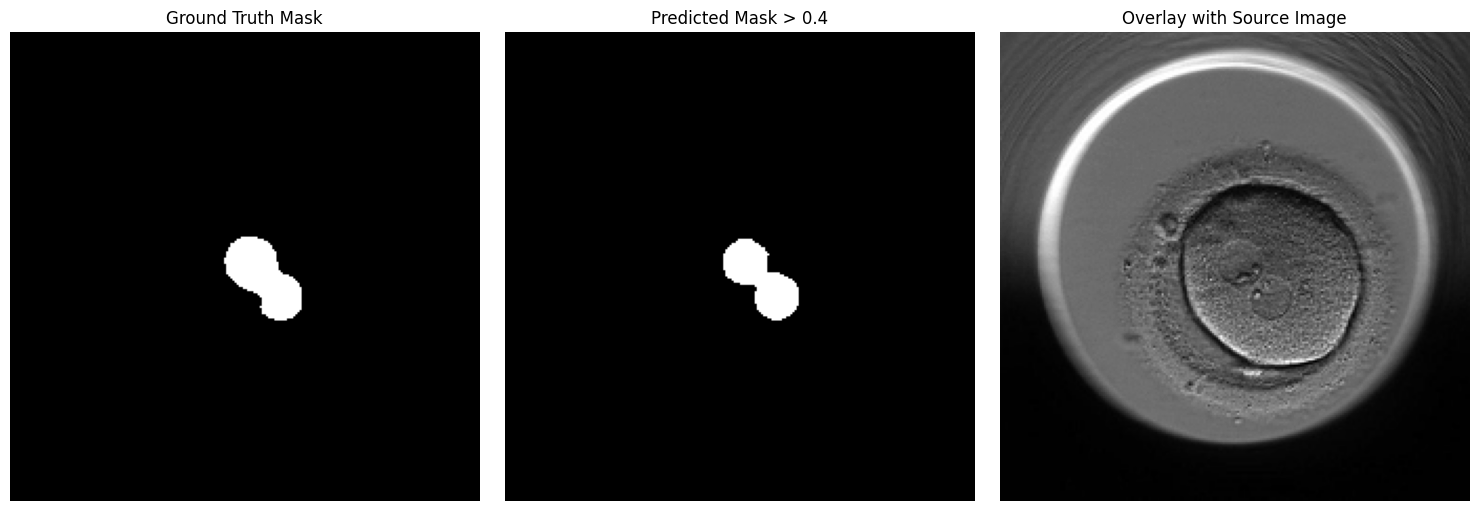

In [102]:
import matplotlib.pyplot as plt

# Assuming 'source_image', 'sample_gt_mask', and 'sample_pred_mask' are numpy arrays
# Display side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original ground truth mask
axes[0].imshow(sample_gt_mask.numpy(), cmap='gray')
axes[0].set_title("Ground Truth Mask")
axes[0].axis('off')

# Prediction mask thresholded
axes[1].imshow(sample_pred_mask > 0.95, cmap='gray')
axes[1].set_title("Predicted Mask > 0.4")
axes[1].axis('off')

# Overlay source image with ground truth and predicted masks
overlay_image = all_images[2][3][0].numpy().copy()
# Adjust overlay to include masks for better visibility

axes[2].imshow(overlay_image, cmap='gray')
axes[2].set_title("Overlay with Source Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [95]:
overlay_image.transpose(1, 2, 0).shape

(224, 224, 3)